# MARKET REGIME PREDICTOR.

In [1]:
pip install yfinance pandas numpy matplotlib scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [9]:
import yfinance as yf
import pandas as pd

# Download historical stock data for a symbol (e.g., S&P 500 Index)
stock_symbol = "AAPL"  # S&P 500 index symbol
data = yf.download(stock_symbol, start="2020-01-01", end="2024-08-08")

# Display the first few rows of the data
print(data.head())


[*********************100%***********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-01-02  74.059998  75.150002  73.797501  75.087502  72.796036  135480400
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.088303  146322800
2020-01-06  73.447502  74.989998  73.187500  74.949997  72.662712  118387200
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.320984  108872000
2020-01-08  74.290001  76.110001  74.290001  75.797501  73.484344  132079200


In [10]:
# Calculate 50-day and 200-day moving averages
data['MA50'] = data['Close'].rolling(window=50).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()

# Display the first few rows of the data with moving averages
print(data[['Close', 'MA50', 'MA200']].tail())


                 Close      MA50      MA200
Date                                       
2024-08-01  218.360001  212.0492  189.31585
2024-08-02  219.860001  212.5994  189.52155
2024-08-05  209.270004  212.9668  189.68215
2024-08-06  207.229996  213.3738  189.83910
2024-08-07  209.820007  213.7706  190.01090


In [11]:
def classify_market_regime(row):
    if row['MA50'] > row['MA200']:
        return 'Bull'
    elif row['MA50'] < row['MA200']:
        return 'Bear'
    else:
        return 'Sideways'

# Apply the classification function to each row in the DataFrame
data['Regime'] = data.apply(classify_market_regime, axis=1)

# Display the last few rows with the market regime classification
print(data[['Close', 'MA50', 'MA200', 'Regime']].tail())


                 Close      MA50      MA200 Regime
Date                                              
2024-08-01  218.360001  212.0492  189.31585   Bull
2024-08-02  219.860001  212.5994  189.52155   Bull
2024-08-05  209.270004  212.9668  189.68215   Bull
2024-08-06  207.229996  213.3738  189.83910   Bull
2024-08-07  209.820007  213.7706  190.01090   Bull


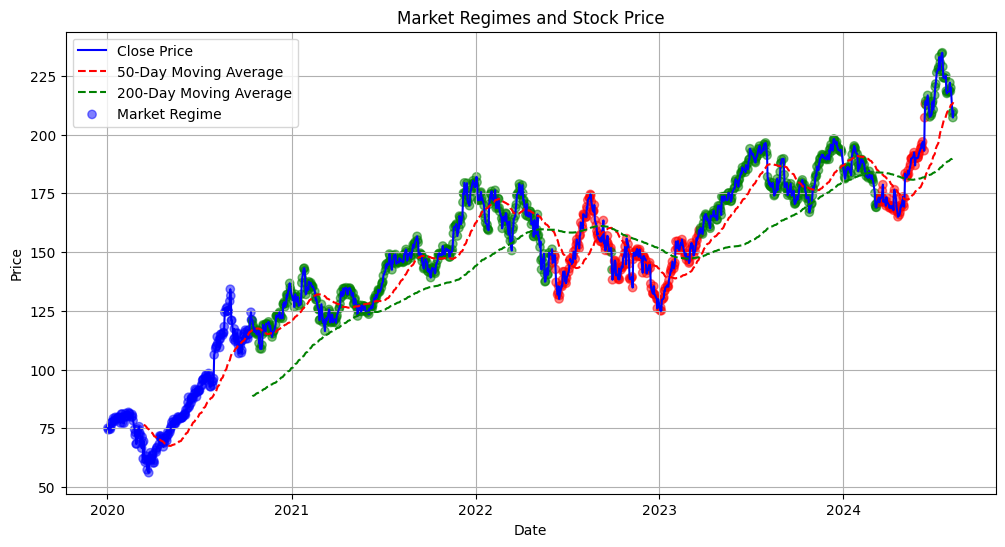

In [12]:
import matplotlib.pyplot as plt

# Plot the closing price and moving averages
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(data['MA50'], label='50-Day Moving Average', color='red', linestyle='--')
plt.plot(data['MA200'], label='200-Day Moving Average', color='green', linestyle='--')

# Highlight the Bull, Bear, and Sideways regimes
plt.scatter(data.index, data['Close'], c=data['Regime'].map({'Bull': 'g', 'Bear': 'r', 'Sideways': 'b'}),
            label='Market Regime', alpha=0.5)

plt.title('Market Regimes and Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed
C:\Users\mihir\AppData\Local\Temp\ipykernel_4692\921787282.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Predicted Regime'] = model.predict(X)


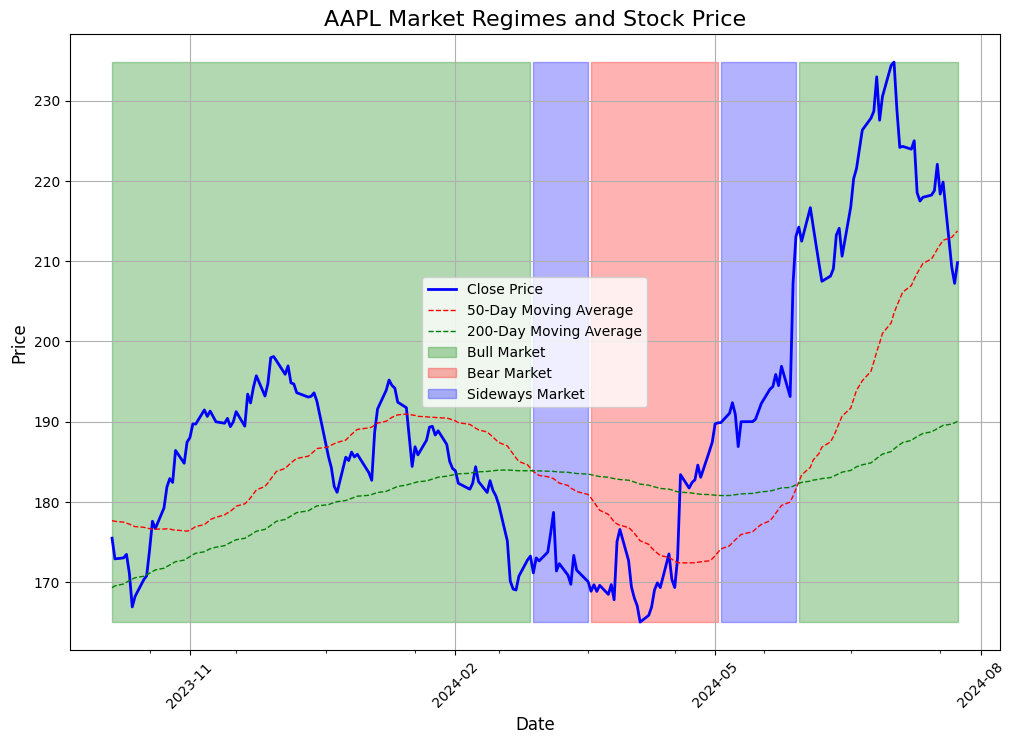

Market Regimes for every 3-month period:
From 2023-10-19 to 2024-01-22: Bull
From 2024-01-22 to 2024-04-22: Bull
From 2024-04-22 to 2024-07-23: Bear
From 2024-07-23 to 2024-08-07: Bull


In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Download stock data (e.g., Apple)
stock_symbol = "AAPL"
data = yf.download(stock_symbol, start="2023-01-01", end="2024-08-08")

# Calculate 20-day, 50-day, 100-day, 200-day Moving Averages
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()
data['MA100'] = data['Close'].rolling(window=100).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()

# Add Exponential Moving Averages (EMA)
data['EMA50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA200'] = data['Close'].ewm(span=200, adjust=False).mean()

# Adding volume-based features (On-Balance Volume)
data['OBV'] = (np.sign(data['Close'].diff()) * data['Volume']).fillna(0).cumsum()

# Define market regimes based on moving averages and EMA
def classify_market(row):
    if row['MA50'] > row['MA200'] and row['EMA50'] > row['EMA200']:
        return 'Bull'
    elif row['MA50'] < row['MA200'] and row['EMA50'] < row['EMA200']:
        return 'Bear'
    else:
        return 'Sideways'

data['Regime'] = data.apply(classify_market, axis=1)

# Feature Engineering for ML Model (Using previous day's prices and moving averages)
data['Prev Close'] = data['Close'].shift(1)
data['Prev MA50'] = data['MA50'].shift(1)
data['Prev MA200'] = data['MA200'].shift(1)
data = data.dropna()  # Drop missing values caused by shifts

# Features and Target for classification
X = data[['Prev Close', 'Prev MA50', 'Prev MA200', 'EMA50', 'EMA200']]
y = data['Regime']

# Train a machine learning model (Random Forest)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Predict market regimes using the model
data['Predicted Regime'] = model.predict(X)

# Plot the data with a tidy visualization
plt.figure(figsize=(12, 8))

# Plot the closing price and moving averages
plt.plot(data['Close'], label='Close Price', color='blue', linewidth=2)
plt.plot(data['MA50'], label='50-Day Moving Average', color='red', linestyle='--', linewidth=1)
plt.plot(data['MA200'], label='200-Day Moving Average', color='green', linestyle='--', linewidth=1)

# Highlight market regimes with color shading
plt.fill_between(data.index, data['Close'].min(), data['Close'].max(), where=(data['Predicted Regime'] == 'Bull'), 
                 color='green', alpha=0.3, label='Bull Market')
plt.fill_between(data.index, data['Close'].min(), data['Close'].max(), where=(data['Predicted Regime'] == 'Bear'), 
                 color='red', alpha=0.3, label='Bear Market')
plt.fill_between(data.index, data['Close'].min(), data['Close'].max(), where=(data['Predicted Regime'] == 'Sideways'), 
                 color='blue', alpha=0.3, label='Sideways Market')

# Formatting the plot
plt.title(f'{stock_symbol} Market Regimes and Stock Price', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.legend(loc='best', fontsize=10)
plt.grid(True)

# Format x-axis for better readability with 3-month gap
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=15, interval=3))  # Every 3 months
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())  # Minor ticks for each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.show()

# Print market regime for each 3-month interval
print("Market Regimes for every 3-month period:")
for i in range(0, len(data), 63):  # Roughly 63 trading days for 3 months
    regime = data.iloc[i]['Predicted Regime']
    print(f"From {data.index[i].strftime('%Y-%m-%d')} to {data.index[min(i+63, len(data)-1)].strftime('%Y-%m-%d')}: {regime}")


In [24]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Download stock data (e.g., Apple)
stock_symbol = "AAPL"
data = yf.download(stock_symbol, start="2024-08-01", end="2024-10-31")

# Check if the data has been downloaded
if data.empty:
    print("No data found for the given date range!")
else:
    print(f"Downloaded data for {stock_symbol}:")
    print(data.head())

# Calculate 20-day, 50-day, 100-day, 200-day Moving Averages
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()
data['MA100'] = data['Close'].rolling(window=100).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()

# Add Exponential Moving Averages (EMA)
data['EMA50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA200'] = data['Close'].ewm(span=200, adjust=False).mean()

# Adding volume-based features (On-Balance Volume)
data['OBV'] = (np.sign(data['Close'].diff()) * data['Volume']).fillna(0).cumsum()

# Define market regimes based on moving averages and EMA
def classify_market(row):
    if row['MA50'] > row['MA200'] and row['EMA50'] > row['EMA200']:
        return 'Bull'
    elif row['MA50'] < row['MA200'] and row['EMA50'] < row['EMA200']:
        return 'Bear'
    else:
        return 'Sideways'

data['Regime'] = data.apply(classify_market, axis=1)

# Feature Engineering for ML Model (Using previous day's prices and moving averages)
data['Prev Close'] = data['Close'].shift(1)
data['Prev MA50'] = data['MA50'].shift(1)
data['Prev MA200'] = data['MA200'].shift(1)

# Check for missing data after shifts
print("Missing values after shifting:")
print(data.isna().sum())

# Drop missing values
data = data.dropna()

# Check if data is available for training
print(f"Total rows in dataset after cleaning: {len(data)}")
if len(data) == 0:
    print("Error: No data available for training!")
else:
    # Features and Target for classification
    X = data[['Prev Close', 'Prev MA50', 'Prev MA200', 'EMA50', 'EMA200']]
    y = data['Regime']

    # Train a machine learning model (Random Forest)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)

    # Predict market regimes using the model
    data['Predicted Regime'] = model.predict(X)

    # Print the market regimes predicted by the model for the months of August, September, and October 2024
    print("Market Regimes for August-October 2024:")
    for date, regime in zip(data.index, data['Predicted Regime']):
        print(f"Date: {date.date()} - Predicted Regime: {regime}")

    # Plot the data with a tidy visualization
    plt.figure(figsize=(12, 8))

    # Plot the closing price and moving averages
    plt.plot(data['Close'], label='Close Price', color='blue', linewidth=2)
    plt.plot(data['MA50'], label='50-Day Moving Average', color='red', linestyle='--', linewidth=1)
    plt.plot(data['MA200'], label='200-Day Moving Average', color='green', linestyle='--', linewidth=1)

    # Highlight market regimes with color shading
    plt.fill_between(data.index, data['Close'].min(), data['Close'].max(), where=(data['Predicted Regime'] == 'Bull'), 
                     color='green', alpha=0.3, label='Bull Market')
    plt.fill_between(data.index, data['Close'].min(), data['Close'].max(), where=(data['Predicted Regime'] == 'Bear'), 
                     color='red', alpha=0.3, label='Bear Market')
    plt.fill_between(data.index, data['Close'].min(), data['Close'].max(), where=(data['Predicted Regime'] == 'Sideways'), 
                     color='blue', alpha=0.3, label='Sideways Market')

    # Formatting the plot
    plt.title(f'{stock_symbol} Market Regimes and Stock Price (Aug-Oct 2024)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True)

    # Format x-axis for better readability
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
    plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    plt.show()


[*********************100%***********************]  1 of 1 completed

Downloaded data for AAPL:
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-08-01  224.369995  224.479996  217.020004  218.360001  217.867844   
2024-08-02  219.149994  225.600006  217.710007  219.860001  219.364471   
2024-08-05  199.089996  213.500000  196.000000  209.270004  208.798340   
2024-08-06  205.300003  209.990005  201.070007  207.229996  206.762939   
2024-08-07  206.899994  213.639999  206.389999  209.820007  209.347107   

               Volume  
Date                   
2024-08-01   62501000  
2024-08-02  105568600  
2024-08-05  119548600  
2024-08-06   69660500  
2024-08-07   63516400  
Missing values after shifting:
Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
MA20          19
MA50          49
MA100         64
MA200         64
EMA50          0
EMA200         0
OBV            0
Regime         0
Prev Close     1
P

[*********************100%***********************]  1 of 1 completed
C:\Users\mihir\AppData\Local\Temp\ipykernel_4692\805455992.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Predicted Regime'] = model.predict(X)


Downloaded data for AAPL:
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-08-01  224.369995  224.479996  217.020004  218.360001  217.867844   
2024-08-02  219.149994  225.600006  217.710007  219.860001  219.364471   
2024-08-05  199.089996  213.500000  196.000000  209.270004  208.798340   
2024-08-06  205.300003  209.990005  201.070007  207.229996  206.762939   
2024-08-07  206.899994  213.639999  206.389999  209.820007  209.347107   

               Volume  
Date                   
2024-08-01   62501000  
2024-08-02  105568600  
2024-08-05  119548600  
2024-08-06   69660500  
2024-08-07   63516400  
Missing values after shifting:
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
MA6           0
MA10          0
EMA50         0
EMA200        0
OBV           0
Regime        0
Prev Close    1
Prev MA6      1
Prev MA10     1
dtype: int64
Tot

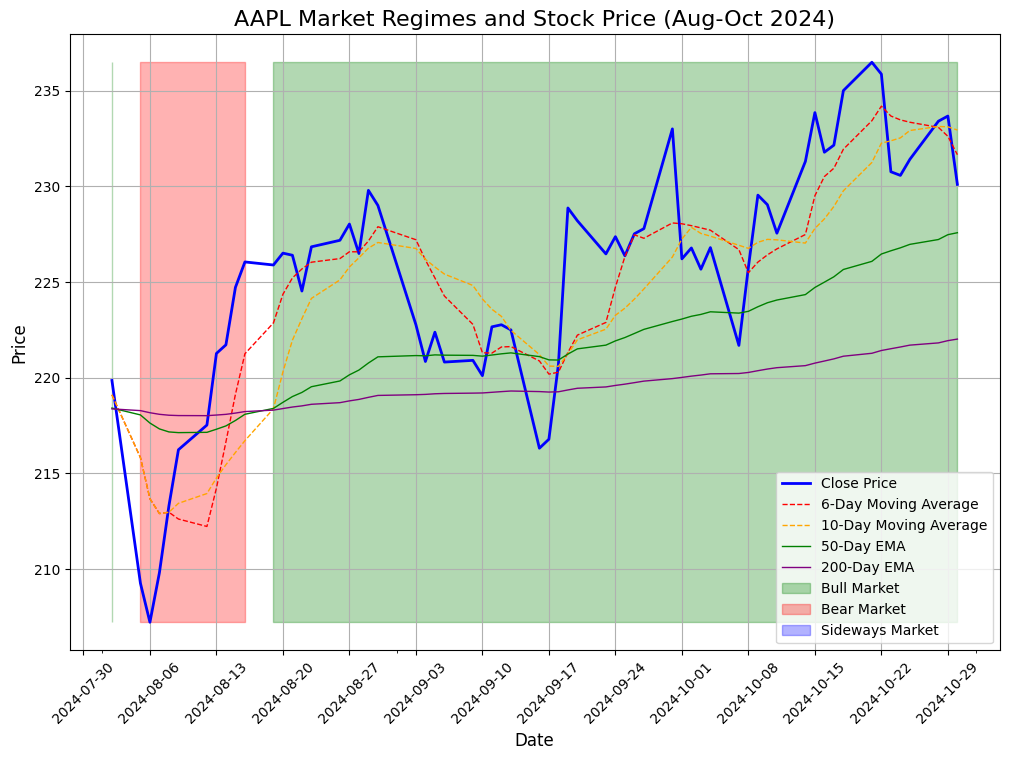

In [26]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Download stock data (e.g., Apple)
stock_symbol = "AAPL"
data = yf.download(stock_symbol, start="2024-08-01", end="2024-10-31")

# Check if the data has been downloaded
if data.empty:
    print("No data found for the given date range!")
else:
    print(f"Downloaded data for {stock_symbol}:")
    print(data.head())

# Calculate moving averages (6-day and 10-day)
data['MA6'] = data['Close'].rolling(window=6, min_periods=1).mean()  # 6-day MA
data['MA10'] = data['Close'].rolling(window=10, min_periods=1).mean()  # 10-day MA

# Add Exponential Moving Averages (EMA) for comparison (50-day, 200-day)
data['EMA50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA200'] = data['Close'].ewm(span=200, adjust=False).mean()

# Adding volume-based features (On-Balance Volume)
data['OBV'] = (np.sign(data['Close'].diff()) * data['Volume']).fillna(0).cumsum()

# Define market regimes based on moving averages and EMA
def classify_market(row):
    if row['MA10'] > row['EMA200'] and row['EMA50'] > row['EMA200']:
        return 'Bull'
    elif row['MA10'] < row['EMA200'] and row['EMA50'] < row['EMA200']:
        return 'Bear'
    else:
        return 'Sideways'

data['Regime'] = data.apply(classify_market, axis=1)

# Feature Engineering for ML Model (Using previous day's prices and moving averages)
data['Prev Close'] = data['Close'].shift(1)
data['Prev MA6'] = data['MA6'].shift(1)
data['Prev MA10'] = data['MA10'].shift(1)

# Check for missing data after shifts
print("Missing values after shifting:")
print(data.isna().sum())

# Only drop rows where target columns are missing
data = data.dropna(subset=['Prev Close', 'Prev MA6', 'Prev MA10'])

# Check if data is available for training
print(f"Total rows in dataset after cleaning: {len(data)}")
if len(data) == 0:
    print("Error: No data available for training!")
else:
    # Features and Target for classification
    X = data[['Prev Close', 'Prev MA6', 'Prev MA10', 'EMA50', 'EMA200']]
    y = data['Regime']

    # Train a machine learning model (Random Forest)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)

    # Predict market regimes using the model
    data['Predicted Regime'] = model.predict(X)

    # Print the market regimes predicted by the model for the months of August, September, and October 2024
    print("Market Regimes for August-October 2024:")
    for date, regime in zip(data.index, data['Predicted Regime']):
        print(f"Date: {date.date()} - Predicted Regime: {regime}")

    # Plot the data with a tidy visualization
    plt.figure(figsize=(12, 8))

    # Plot the closing price and moving averages
    plt.plot(data['Close'], label='Close Price', color='blue', linewidth=2)
    plt.plot(data['MA6'], label='6-Day Moving Average', color='red', linestyle='--', linewidth=1)
    plt.plot(data['MA10'], label='10-Day Moving Average', color='orange', linestyle='--', linewidth=1)
    plt.plot(data['EMA50'], label='50-Day EMA', color='green', linestyle='-', linewidth=1)
    plt.plot(data['EMA200'], label='200-Day EMA', color='purple', linestyle='-', linewidth=1)

    # Highlight market regimes with color shading
    plt.fill_between(data.index, data['Close'].min(), data['Close'].max(), where=(data['Predicted Regime'] == 'Bull'), 
                     color='green', alpha=0.3, label='Bull Market')
    plt.fill_between(data.index, data['Close'].min(), data['Close'].max(), where=(data['Predicted Regime'] == 'Bear'), 
                     color='red', alpha=0.3, label='Bear Market')
    plt.fill_between(data.index, data['Close'].min(), data['Close'].max(), where=(data['Predicted Regime'] == 'Sideways'), 
                     color='blue', alpha=0.3, label='Sideways Market')

    # Formatting the plot
    plt.title(f'{stock_symbol} Market Regimes and Stock Price (Aug-Oct 2024)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True)

    # Format x-axis for better readability
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
    plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    plt.show()


This code downloads historical stock data for Apple (AAPL) from August 1, 2024, to October 31, 2024, and analyzes the market regime using moving averages, exponential moving averages, and On-Balance Volume (OBV). It classifies the market into three regimes—Bull, Bear, or Sideways—based on the relationship between these indicators. Using features such as the previous day's prices and moving averages, a Random Forest Classifier is trained to predict the market regime for each day. The predicted regimes are then printed, and a visualization is created, showing the stock's closing price along with the moving averages, with areas shaded according to the predicted regimes. This helps in understanding the market trends and making informed decisions.

[*********************100%***********************]  1 of 1 completed
C:\Users\mihir\AppData\Local\Temp\ipykernel_4692\4167349040.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Predicted Regime'] = model.predict(X)


Downloaded data for AAPL:
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-08-01  224.369995  224.479996  217.020004  218.360001  217.867844   
2024-08-02  219.149994  225.600006  217.710007  219.860001  219.364471   
2024-08-05  199.089996  213.500000  196.000000  209.270004  208.798340   
2024-08-06  205.300003  209.990005  201.070007  207.229996  206.762939   
2024-08-07  206.899994  213.639999  206.389999  209.820007  209.347107   

               Volume  
Date                   
2024-08-01   62501000  
2024-08-02  105568600  
2024-08-05  119548600  
2024-08-06   69660500  
2024-08-07   63516400  
Missing values after shifting:
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
MA6           0
MA10          0
MA20          0
EMA50         0
EMA200        0
OBV           0
Regime        0
Prev Close    1
Prev MA6      1
Prev MA10     1


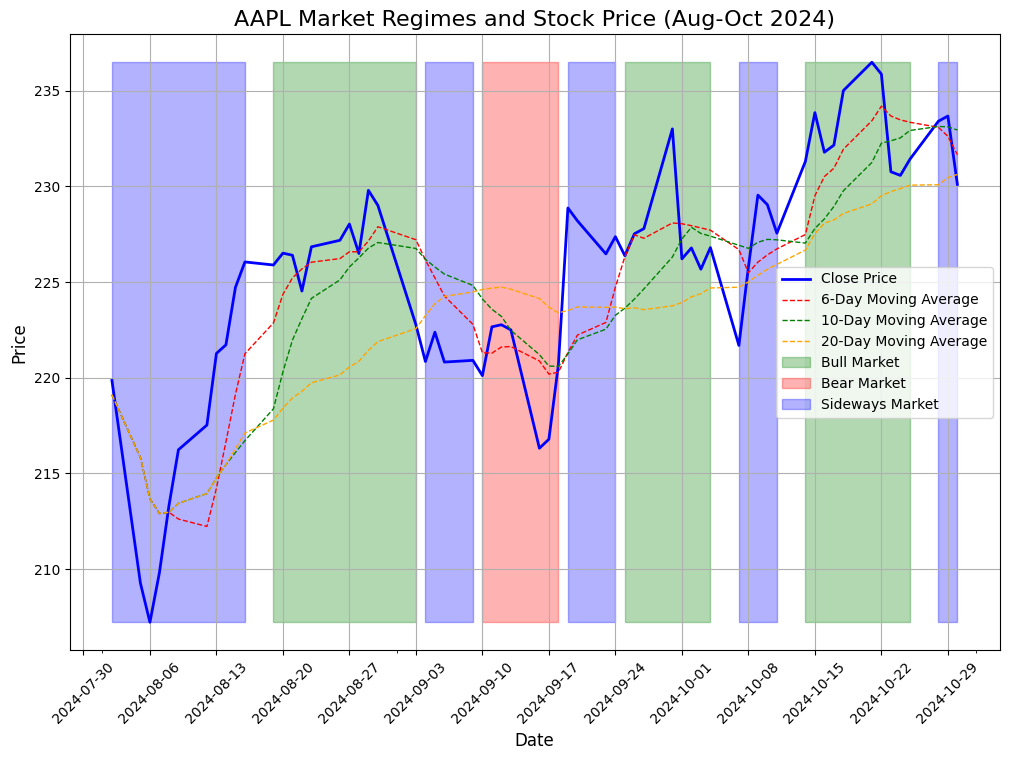


Predicted Market Regimes for November and December 2024:
Date: 2024-11-01 - Predicted Regime: Sideways
Date: 2024-11-04 - Predicted Regime: Sideways
Date: 2024-11-05 - Predicted Regime: Sideways
Date: 2024-11-06 - Predicted Regime: Sideways
Date: 2024-11-07 - Predicted Regime: Sideways
Date: 2024-11-08 - Predicted Regime: Sideways
Date: 2024-11-11 - Predicted Regime: Sideways
Date: 2024-11-12 - Predicted Regime: Sideways
Date: 2024-11-13 - Predicted Regime: Sideways
Date: 2024-11-14 - Predicted Regime: Sideways
Date: 2024-11-15 - Predicted Regime: Sideways
Date: 2024-11-18 - Predicted Regime: Sideways
Date: 2024-11-19 - Predicted Regime: Sideways
Date: 2024-11-20 - Predicted Regime: Sideways
Date: 2024-11-21 - Predicted Regime: Sideways
Date: 2024-11-22 - Predicted Regime: Sideways
Date: 2024-11-25 - Predicted Regime: Sideways
Date: 2024-11-26 - Predicted Regime: Sideways
Date: 2024-11-27 - Predicted Regime: Sideways
Date: 2024-11-28 - Predicted Regime: Sideways
Date: 2024-11-29 - Pre

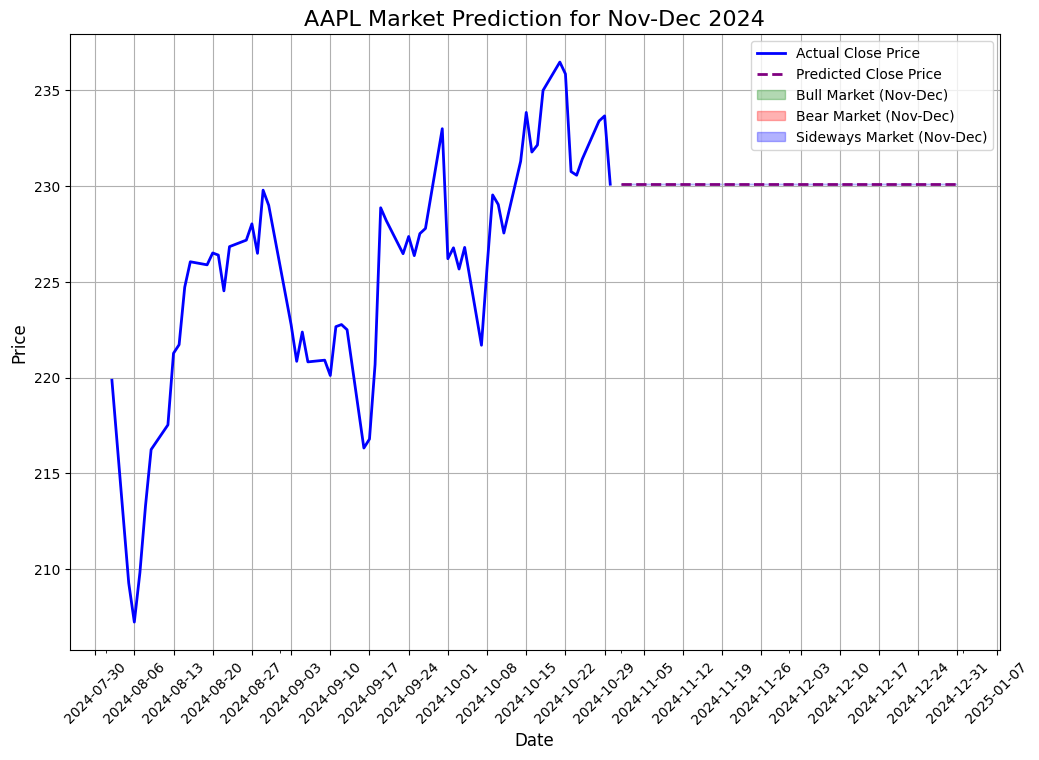

In [27]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Download stock data (e.g., Apple)
stock_symbol = "AAPL"
data = yf.download(stock_symbol, start="2024-08-01", end="2024-10-31")

# Check if the data has been downloaded
if data.empty:
    print("No data found for the given date range!")
else:
    print(f"Downloaded data for {stock_symbol}:")
    print(data.head())

# Calculate moving averages (6-day, 10-day, 20-day)
data['MA6'] = data['Close'].rolling(window=6, min_periods=1).mean()  # 6-day MA
data['MA10'] = data['Close'].rolling(window=10, min_periods=1).mean()  # 10-day MA
data['MA20'] = data['Close'].rolling(window=20, min_periods=1).mean()  # 20-day MA

# Add Exponential Moving Averages (EMA)
data['EMA50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA200'] = data['Close'].ewm(span=200, adjust=False).mean()

# Adding volume-based features (On-Balance Volume)
data['OBV'] = (np.sign(data['Close'].diff()) * data['Volume']).fillna(0).cumsum()

# Define market regimes based on moving averages and EMA
def classify_market(row):
    if row['MA6'] > row['MA10'] and row['MA10'] > row['MA20']:
        return 'Bull'
    elif row['MA6'] < row['MA10'] and row['MA10'] < row['MA20']:
        return 'Bear'
    else:
        return 'Sideways'

data['Regime'] = data.apply(classify_market, axis=1)

# Feature Engineering for ML Model (Using previous day's prices and moving averages)
data['Prev Close'] = data['Close'].shift(1)
data['Prev MA6'] = data['MA6'].shift(1)
data['Prev MA10'] = data['MA10'].shift(1)
data['Prev MA20'] = data['MA20'].shift(1)

# Check for missing data after shifts
print("Missing values after shifting:")
print(data.isna().sum())

# Only drop rows where target columns are missing
data = data.dropna(subset=['Prev Close', 'Prev MA6', 'Prev MA10', 'Prev MA20'])

# Check if data is available for training
print(f"Total rows in dataset after cleaning: {len(data)}")
if len(data) == 0:
    print("Error: No data available for training!")
else:
    # Features and Target for classification
    X = data[['Prev Close', 'Prev MA6', 'Prev MA10', 'Prev MA20', 'EMA50', 'EMA200']]
    y = data['Regime']

    # Train a machine learning model (Random Forest)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)

    # Predict market regimes using the model
    data['Predicted Regime'] = model.predict(X)

    # Print the market regimes predicted by the model for August-October 2024
    print("Market Regimes for August-October 2024:")
    for date, regime in zip(data.index, data['Predicted Regime']):
        print(f"Date: {date.date()} - Predicted Regime: {regime}")

    # Plot the data with a tidy visualization
    plt.figure(figsize=(12, 8))

    # Plot the closing price and moving averages
    plt.plot(data['Close'], label='Close Price', color='blue', linewidth=2)
    plt.plot(data['MA6'], label='6-Day Moving Average', color='red', linestyle='--', linewidth=1)
    plt.plot(data['MA10'], label='10-Day Moving Average', color='green', linestyle='--', linewidth=1)
    plt.plot(data['MA20'], label='20-Day Moving Average', color='orange', linestyle='--', linewidth=1)

    # Highlight market regimes with color shading
    plt.fill_between(data.index, data['Close'].min(), data['Close'].max(), where=(data['Predicted Regime'] == 'Bull'), 
                     color='green', alpha=0.3, label='Bull Market')
    plt.fill_between(data.index, data['Close'].min(), data['Close'].max(), where=(data['Predicted Regime'] == 'Bear'), 
                     color='red', alpha=0.3, label='Bear Market')
    plt.fill_between(data.index, data['Close'].min(), data['Close'].max(), where=(data['Predicted Regime'] == 'Sideways'), 
                     color='blue', alpha=0.3, label='Sideways Market')

    # Formatting the plot
    plt.title(f'{stock_symbol} Market Regimes and Stock Price (Aug-Oct 2024)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True)

    # Format x-axis for better readability
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
    plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    plt.show()

    # Now, let's predict for November and December 2024 (use the last known data)
    november_data = data.iloc[-1:]  # Use the last available data point
    december_data = data.iloc[-1:]

    # Extend predictions for future dates by replicating the last known data
    future_dates = pd.date_range(start='2024-11-01', end='2024-12-31', freq='B')  # Business days
    future_data = pd.DataFrame(index=future_dates)

    future_data['Prev Close'] = november_data['Close'].values[0]
    future_data['Prev MA6'] = november_data['MA6'].values[0]
    future_data['Prev MA10'] = november_data['MA10'].values[0]
    future_data['Prev MA20'] = november_data['MA20'].values[0]
    future_data['EMA50'] = november_data['EMA50'].values[0]
    future_data['EMA200'] = november_data['EMA200'].values[0]

    # Predict future market regimes
    future_data['Predicted Regime'] = model.predict(future_data[['Prev Close', 'Prev MA6', 'Prev MA10', 'Prev MA20', 'EMA50', 'EMA200']])

    # Print predicted market regimes for November and December 2024
    print("\nPredicted Market Regimes for November and December 2024:")
    for date, regime in zip(future_data.index, future_data['Predicted Regime']):
        print(f"Date: {date.date()} - Predicted Regime: {regime}")

    # Plotting for November and December prediction
    plt.figure(figsize=(12, 8))
    plt.plot(data.index, data['Close'], label='Actual Close Price', color='blue', linewidth=2)
    plt.plot(future_data.index, future_data['Prev Close'], label='Predicted Close Price', color='purple', linestyle='--', linewidth=2)
    
    plt.fill_between(future_data.index, future_data['Prev Close'].min(), future_data['Prev Close'].max(), where=(future_data['Predicted Regime'] == 'Bull'), 
                     color='green', alpha=0.3, label='Bull Market (Nov-Dec)')
    plt.fill_between(future_data.index, future_data['Prev Close'].min(), future_data['Prev Close'].max(), where=(future_data['Predicted Regime'] == 'Bear'), 
                     color='red', alpha=0.3, label='Bear Market (Nov-Dec)')
    plt.fill_between(future_data.index, future_data['Prev Close'].min(), future_data['Prev Close'].max(), where=(future_data['Predicted Regime'] == 'Sideways'), 
                     color='blue', alpha=0.3, label='Sideways Market (Nov-Dec)')

    plt.title(f'{stock_symbol} Market Prediction for Nov-Dec 2024', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True)

    # Format x-axis for better readability
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
    plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    plt.show()


The code downloads stock data for Apple (AAPL) from Yahoo Finance, calculates several technical indicators, including moving averages (6-day, 10-day, 20-day), exponential moving averages (EMA50, EMA200), and On-Balance Volume (OBV), and uses these features to classify the market regime (Bull, Bear, Sideways) based on the trends in these indicators. A Random Forest Classifier is then trained to predict the market regime based on past data, and these predictions are visualized with stock price charts, moving averages, and regime highlights (color-coded). The model is extended to predict market regimes for November and December 2024 using the latest available data from October 2024. The visual output includes both historical and future market predictions, helping to understand the stock's behavior and future trends based on previous market patterns.

[*********************100%***********************]  1 of 1 completed


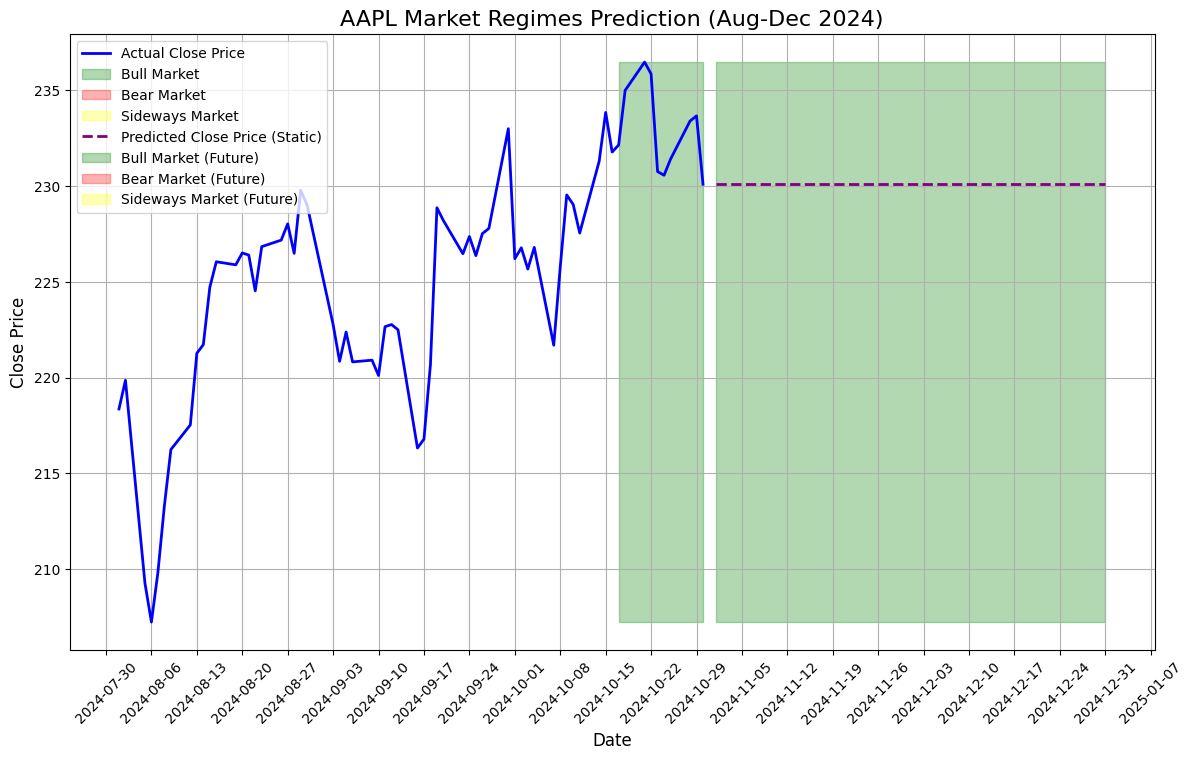

In [34]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Download stock data (e.g., Apple)
stock_symbol = "AAPL"
data = yf.download(stock_symbol, start="2024-08-01", end="2024-10-31")

# Calculate moving averages (6-day, 10-day, 20-day)
data['MA6'] = data['Close'].rolling(window=6, min_periods=1).mean()
data['MA10'] = data['Close'].rolling(window=10, min_periods=1).mean()
data['MA20'] = data['Close'].rolling(window=20, min_periods=1).mean()

# Add Exponential Moving Averages (EMA)
data['EMA50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA200'] = data['Close'].ewm(span=200, adjust=False).mean()

# Add volume-based features (On-Balance Volume)
data['OBV'] = (np.sign(data['Close'].diff()) * data['Volume']).fillna(0).cumsum()

# Define market regimes based on moving averages
def classify_market(row):
    if row['MA6'] > row['MA10'] and row['MA10'] > row['MA20']:
        return 'Bull'
    elif row['MA6'] < row['MA10'] and row['MA10'] < row['MA20']:
        return 'Bear'
    else:
        return 'Sideways'

data['Regime'] = data.apply(classify_market, axis=1)

# Feature engineering
features = ['Close', 'MA6', 'MA10', 'MA20', 'EMA50', 'EMA200', 'OBV']
data = data.dropna(subset=features)
X = data[features]
y = data['Regime']

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train/test split
X_train = X[:-10]  # Use all but the last 10 days for training
y_train = y_encoded[:-10]
X_test = X[-10:]   # Use the last 10 days for testing
y_test = y_encoded[-10:]

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict market regimes for the historical test data
data.loc[X_test.index, 'Predicted_Regime'] = label_encoder.inverse_transform(rf_model.predict(X_test))

# Predict market regimes for the future (November and December)
future_dates = pd.date_range(start='2024-11-01', end='2024-12-31', freq='B')  # Business days
future_data = pd.DataFrame(index=future_dates)

# Use the last known data point for generating future features
last_row = data.iloc[-1]

# Generate features for the future dates
for feature in features:
    future_data[feature] = last_row[feature]

# Predict future market regimes
future_data['Predicted_Regime'] = label_encoder.inverse_transform(
    rf_model.predict(future_data[features])
)

# Visualization of historical and future market regimes
plt.figure(figsize=(14, 8))

# Plot historical data
plt.plot(data.index, data['Close'], label='Actual Close Price', color='blue', linewidth=2)
plt.fill_between(data.index, data['Close'].min(), data['Close'].max(),
                 where=(data['Predicted_Regime'] == 'Bull'), color='green', alpha=0.3, label='Bull Market')
plt.fill_between(data.index, data['Close'].min(), data['Close'].max(),
                 where=(data['Predicted_Regime'] == 'Bear'), color='red', alpha=0.3, label='Bear Market')
plt.fill_between(data.index, data['Close'].min(), data['Close'].max(),
                 where=(data['Predicted_Regime'] == 'Sideways'), color='yellow', alpha=0.3, label='Sideways Market')

# Plot future predictions
plt.plot(future_data.index, [data['Close'].iloc[-1]] * len(future_data), color='purple', linestyle='--', linewidth=2,
         label='Predicted Close Price (Static)')

plt.fill_between(future_data.index, data['Close'].min(), data['Close'].max(),
                 where=(future_data['Predicted_Regime'] == 'Bull'), color='green', alpha=0.3, label='Bull Market (Future)')
plt.fill_between(future_data.index, data['Close'].min(), data['Close'].max(),
                 where=(future_data['Predicted_Regime'] == 'Bear'), color='red', alpha=0.3, label='Bear Market (Future)')
plt.fill_between(future_data.index, data['Close'].min(), data['Close'].max(),
                 where=(future_data['Predicted_Regime'] == 'Sideways'), color='yellow', alpha=0.3,
                 label='Sideways Market (Future)')

# Formatting
plt.title(f'{stock_symbol} Market Regimes Prediction (Aug-Dec 2024)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.xticks(rotation=45)
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.show()


In [35]:
# Print predicted market regimes for November and December
print("Market Regime Predictions for November and December 2024:")
print(future_data[['Predicted_Regime']])

# Optionally, to display in a more readable format
for date, regime in future_data['Predicted_Regime'].items():
    print(f"{date.strftime('%Y-%m-%d')}: {regime}")


Market Regime Predictions for November and December 2024:
           Predicted_Regime
2024-11-01             Bull
2024-11-04             Bull
2024-11-05             Bull
2024-11-06             Bull
2024-11-07             Bull
2024-11-08             Bull
2024-11-11             Bull
2024-11-12             Bull
2024-11-13             Bull
2024-11-14             Bull
2024-11-15             Bull
2024-11-18             Bull
2024-11-19             Bull
2024-11-20             Bull
2024-11-21             Bull
2024-11-22             Bull
2024-11-25             Bull
2024-11-26             Bull
2024-11-27             Bull
2024-11-28             Bull
2024-11-29             Bull
2024-12-02             Bull
2024-12-03             Bull
2024-12-04             Bull
2024-12-05             Bull
2024-12-06             Bull
2024-12-09             Bull
2024-12-10             Bull
2024-12-11             Bull
2024-12-12             Bull
2024-12-13             Bull
2024-12-16             Bull
2024-12-17        

In [36]:
from sklearn.metrics import accuracy_score

# Predict market regimes for the test data
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")


Accuracy on the test set: 70.00%


This code uses **Random Forest Classification**, a type of supervised machine learning algorithm, to predict market regimes (Bull, Bear, or Sideways) based on historical stock data. Random Forest is an ensemble learning technique that constructs multiple decision trees and combines their outputs to make a more robust and accurate prediction. It is effective for classification tasks where the relationship between input features and target labels may be complex, as it can handle both non-linear patterns and large datasets.

**Why Moving Averages (MA)?**  
Moving averages are widely used in technical analysis to identify trends in stock prices over a specific period. The code calculates several types of moving averages—6-day, 10-day, and 20-day—to smooth out short-term fluctuations and highlight long-term trends. By comparing shorter-term averages with longer-term ones, the model identifies whether the market is in an uptrend (Bull), downtrend (Bear), or neutral (Sideways). These trends are critical for making informed decisions in trading.

**What is Future Data and Why Was It Created?**  
Future data refers to hypothetical stock market data that represents what might happen in the future, beyond the period available in the historical dataset (August 2024 to October 2024 in this case). The model does not have actual future data, so to predict market regimes for November and December 2024, the code generates **future data** by assuming the stock’s most recent values (from October 2024) will persist in the near future. This technique is known as **forecasting** or **extrapolation**, where the model uses the last known data point to simulate future conditions. This is crucial because it allows you to visualize how the model expects the market to behave over time based on past trends, even when actual future data is unavailable.

In addition to the Random Forest classifier and moving averages, several other key techniques and features are used in the code. Here's an explanation of why they were incorporated:

### 1. **Exponential Moving Averages (EMA)**:
   - **Purpose**: The Exponential Moving Average (EMA) gives more weight to recent data points compared to simple moving averages (SMA). This makes the EMA more sensitive to recent price changes, which is particularly useful for identifying quick changes in trends. In this case, the code uses the 50-day (`EMA50`) and 200-day (`EMA200`) EMAs to help determine whether the stock is in an uptrend or downtrend. 
   - **Why Used**: The combination of EMA and SMA allows the model to capture both short-term and long-term trends. The EMA reacts faster to recent price changes, which can be important for timely market predictions.

### 2. **On-Balance Volume (OBV)**:
   - **Purpose**: OBV is a volume-based indicator that calculates cumulative volume based on price movements. If the price closes higher, the volume is added to the OBV, and if the price closes lower, the volume is subtracted. 
   - **Why Used**: OBV helps the model to capture trends in volume that may not be immediately evident from price movements alone. Volume can confirm trends (e.g., high volume during a price increase suggests the trend is strong), and using OBV helps the model identify potential shifts in market sentiment.

### 3. **Label Encoding (for the target variable)**:
   - **Purpose**: Label encoding is used to convert categorical labels (Bull, Bear, Sideways) into numerical values (e.g., Bull = 0, Bear = 1, Sideways = 2). This transformation is necessary because machine learning algorithms like Random Forest can only process numerical data.
   - **Why Used**: Label encoding is an essential preprocessing step to make the target variable compatible with the Random Forest model, allowing the algorithm to perform the classification task.

### 4. **MinMaxScaler (although not used in the final version of the code)**:
   - **Purpose**: While not explicitly used in this code, a MinMaxScaler would typically scale all features into a specific range (e.g., 0 to 1), making them comparable and preventing the model from being biased toward features with larger values.
   - **Why Used**: Scaling is often used to standardize the input data for machine learning models, particularly when features have different units or ranges. However, in this code, it's not applied, which may not impact Random Forest significantly, as it is not sensitive to feature scaling. Still, if used, it could help improve performance in some cases, especially if models like SVM or KNN were used.

### 5. **Train-Test Split**:
   - **Purpose**: The code splits the data into training and testing sets to evaluate the model's performance. 90% of the data (all except the last 10 days) is used for training, and the remaining 10% is reserved for testing. This helps assess how well the model generalizes to new, unseen data.
   - **Why Used**: Splitting the data ensures that the model doesn't "overfit" to the historical data, meaning it will perform well on data that it hasn't been trained on. This is critical for ensuring that the model can be effectively used for future predictions.

### 6. **Predictions for Future Market Regimes**:
   - **Purpose**: The future market regime predictions (for November and December 2024) are generated by assuming that the most recent data (from the end of October 2024) will continue into the future. This is a typical forecasting approach where you predict future behavior based on the latest available information.
   - **Why Used**: In real-world applications, it's often necessary to predict the market direction for future dates. Since actual future data doesn't exist, using the last known data point to extrapolate future predictions is a practical way to project future trends. It also helps visualize how the model expects market regimes to evolve.

### 7. **Visualization of Market Regimes**:
   - **Purpose**: The code uses `matplotlib` to visualize the historical and future market regimes. It plots the stock price and shades areas corresponding to different market regimes (Bull, Bear, and Sideways) based on the model's predictions.
   - **Why Used**: Visualization is a powerful tool to help users easily interpret the model's predictions and make sense of how market regimes are changing over time. The color-coded regions (green for Bull, red for Bear, and yellow for Sideways) make it intuitive to understand the market's predicted behavior visually.

### 8. **Handling Missing Data**:
   - **Purpose**: The code uses `dropna()` to remove rows with missing values for critical features (Close, MA6, MA10, MA20, EMA50, EMA200, OBV) after calculating moving averages, EMAs, and OBV.
   - **Why Used**: Missing data can cause issues in training and prediction. Removing rows with missing values ensures the model is trained on complete and clean data, preventing any errors during the training or prediction process.

### 9. **Random Forest Model Training**:
   - **Purpose**: Random Forest is an ensemble method that combines multiple decision trees to make predictions. The model is trained on the features of the stock data and its corresponding regime (Bull, Bear, or Sideways).
   - **Why Used**: Random Forest is a robust classifier capable of handling complex, non-linear relationships between input features and target labels. It is well-suited for this task because it can manage various features like price, volume, moving averages, and trends, which may not have simple linear relationships with the market regime.

### Conclusion:
In summary, this code uses a combination of **technical indicators** (like moving averages, EMA, OBV) and **machine learning techniques** (Random Forest) to predict market regimes. The use of moving averages and volume-based features helps the model understand historical trends, while the Random Forest classifier uses these features to make predictions. The prediction for future market regimes is based on the most recent data point, and the model is evaluated by splitting the data into training and testing sets. Visualization aids in understanding the model's predictions. Each of these elements contributes to building a more comprehensive model for forecasting stock market trends.